In [1]:
import cv2
import torch
import matplotlib.pyplot as plt

/home/cosmic/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)


Using cache found in /home/cosmic/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/cosmic/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in /home/cosmic/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
img = cv2.imread("/home/cosmic/WorkSpace/DeepLearnReact/backend/assets/test3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)


In [6]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()


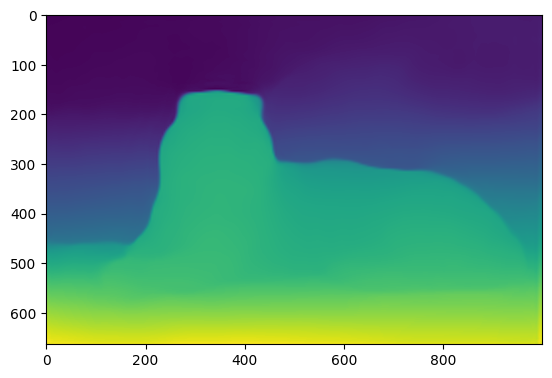

In [7]:
plt.imshow(output)
# plt.show()

In [8]:
torch.save(midas.state_dict(), 'midas.pt')
# Save model

Using cache found in /home/cosmic/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/cosmic/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


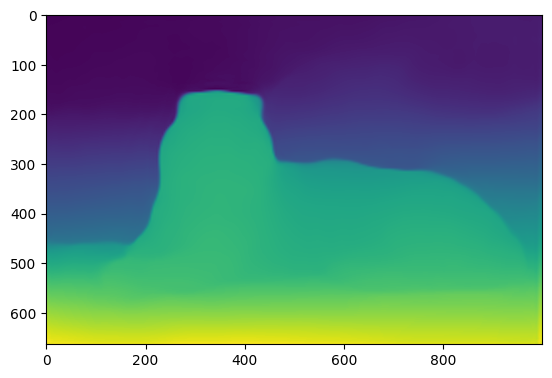

In [9]:
# Create a new instance of the MiDaS model
new_midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
new_midas.to(device)
new_midas.eval()

# Load the saved state dictionary into the new model
new_midas.load_state_dict(torch.load('midas.pt'))

# Use the new model for inference
input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = new_midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()
plt.imshow(output)
plt.show()
